In [29]:
import os
import math
import pandas as pd
import numpy as np
import random
import statistics
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn
from matplotlib.pyplot import figure
from datetime import datetime, timedelta
from collections import OrderedDict

In [30]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
calibration_df = pd.read_csv("Inputs/Calibration/calibration.csv")

# <font color = purple> Reservoir Operations </font>
## 1. <font color = blue> Itezhi Tehzi operations </font>

### - <font color = purple> volume-depth relationships </font>

In [31]:
#Power function to describe the relationship between AREA and DEPTH (eg. Area = f(Depth)) and and inverse power function to describe the relationship between VOLUME and DEPTH (e.g. Volume = f(Depth))
def itezhi_tehzi_volume(depth):
    #returns volume in millions of cubic meters (MCM) for a depth provided in meters
    return 0.00193732425437*depth**3.68873532258572
def itezhi_tehzi_depth(volume):
    #returns depth in meters for a volume provided in millions of cubic meters
    return (volume / 0.00193732425437) ** (1 / 3.68873532258572)

### - <font color = purple> hydropower release </font>
<font color = blue> demanded release volume (in millions of cubic meters) </font>

In [32]:
it_target = 96 # megawatts per month
it_efficiency = 0.90 * 0.88 #(1- headloss) * turbine_efficiency
it_initial_volume = 3854.577127 #volume in mcm

In [33]:
def hydropower_demand_release(reservoir_depth_previous, month, efficiency, target):
    #returns volume of demanded release in mcm
    #requires 'reservoir_depth' in m, 'month' as numeric value [1, 12], 'efficiency' (portion of theoretical maximum converted to electrical power) unitless number [0, 1], 'target' in megawatts per month
    days_in_month = { 1:31, 2:28.25, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31 }
    # 1000 = density of water (kg/m3), 9.81 acceleration of gravity (m/s2), 86400 (sec/month)
    return (target / (1000 * 9.81 * reservoir_depth_previous * efficiency)) * 86400 * days_in_month[month]

<font color = blue> gated release (in millions of cubic meters) </font>

In [34]:
it_deadpool_volume = 774 #in mcm

In [35]:
#Release in millions of cubic meters (MCM)
def reservoir_gated_release(reservoir_volume_previous, deadpool_volume, inflow, hydropower_demand_release):
    #Min = the smaller of the hydropower demand -OR- usable reservoir volume, Max = 0 or positive release 
    return max(0, min(hydropower_demand_release, reservoir_volume_previous - deadpool_volume + inflow))

### - <font color = purple> reservoir spilled releases </font>

In [36]:
it_surcharge_volume = 6000 # millions of cubic meters (MCM)

In [37]:
def reservoir_spilled_release(reservoir_volume, inflow, gated_release, surcharge_volume):
    return max(0, reservoir_volume + inflow - gated_release - surcharge_volume)

### - <font color = purple> reservoir volume </font>

In [38]:
it_losses = 0.10 # mcm per month assumed to scale proportionally with reservoir volume

In [39]:
def reservoir_volume(volume_previous, inflow, gated_release, spilled_release, loss_max, surcharge_volume):
    return volume_previous + inflow - gated_release - spilled_release - loss_max * (volume_previous / surcharge_volume)

## 2. <font color = blue> Itezhi Tehzi calibration period computation </font>

In [40]:
def itezhi_tehzi_reservoir(df, initial_volume, deadpool_volume, surcharge_volume, efficiency, target, losses):
    volume = initial_volume
    for index, row in df.iterrows():
        demand = hydropower_demand_release(itezhi_tehzi_depth(it_volume), row['month'], efficiency, target)
        release = reservoir_gated_release(volume, deadpool_volume, row['it_streamflow'], demand)
        spill = reservoir_spilled_release(volume, row['it_streamflow'], release, surcharge_volume)
        volume = reservoir_volume(volume, row['it_streamflow'], release, spill, losses, surcharge_volume)
        outflow = release + spill
        df.at[index,'it_volume'] = volume
        df.at[index,'it_hydro_demand'] = demand
        df.at[index,'it_gated_release'] = release
        df.at[index,'it_spilled_release'] = spill
        df.at[index,'it_outflow'] = outflow
    return df

In [41]:
it_target = it_target
it_losses = it_losses
it_efficiency = it_efficiency
it_volume = it_initial_volume
it_deadpool = it_deadpool_volume
it_surcharge = it_surcharge_volume
calibration_df = itezhi_tehzi_reservoir(calibration_df, it_volume, it_deadpool_volume, it_surcharge_volume, it_efficiency, it_target, it_losses)
calibration_df.head()

,timestep,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,...,kg_baseflow,it_runoff,kg_runoff,it_streamflow,kg_streamflow,it_volume,it_hydro_demand,it_gated_release,it_spilled_release,it_outflow
0,1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.410688,...,565.656000,3.516052e+03,1.744628e+03,4656.051958,2310.283970,5999.935757,648.906769,648.906769,1861.722316,2510.629085
1,2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.983190,...,851.504682,1.988107e+03,9.864780e+02,3704.195241,1837.982687,5999.900001,591.342459,591.342459,3112.788539,3704.130998
2,3,1,3,97.6,17,29,155.684118,13.289974,221.110468,62.670465,...,1012.762928,1.556272e-01,7.722060e-02,2041.236669,1012.840149,5999.900002,648.906769,648.906769,1392.229901,2041.136670
3,4,1,4,5.6,14,29,169.238425,0.776610,148.598863,15.582097,...,833.816420,3.796963e-12,1.884013e-12,1680.439559,833.816420,5999.900002,627.974292,627.974292,1052.365268,1680.339560
4,5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.754996,...,560.372256,0.000000e+00,0.000000e+00,1129.351359,560.372256,5999.900002,648.906769,648.906769,480.344592,1129.251361


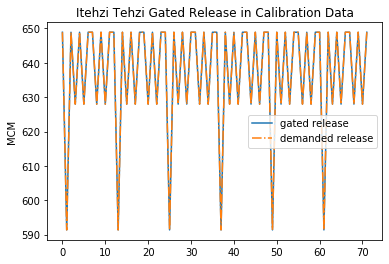

In [42]:
streamflow_figure = plt.figure()
streamflow_figure = plt.title('Itehzi Tehzi Gated Release in Calibration Data')
streamflow_figure = plt.ylabel("MCM")
streamflow_figure = plt.plot(calibration_df.index, calibration_df['it_gated_release'], label = 'gated release')
streamflow_figure = plt.plot(calibration_df.index, calibration_df['it_hydro_demand'], linestyle = '-.', label = 'demanded release')
streamflow_figure = plt.legend()
streamflow_figure = plt.show()

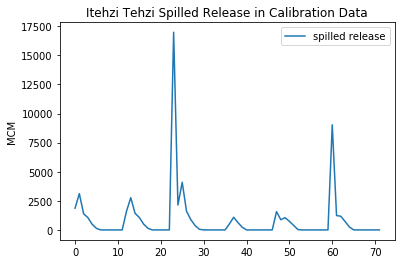

In [43]:
streamflow_figure = plt.figure()
streamflow_figure = plt.title('Itehzi Tehzi Spilled Release in Calibration Data')
streamflow_figure = plt.ylabel("MCM")
streamflow_figure = plt.plot(calibration_df.index, calibration_df['it_spilled_release'], label = 'spilled release')
streamflow_figure = plt.legend()
streamflow_figure = plt.show()

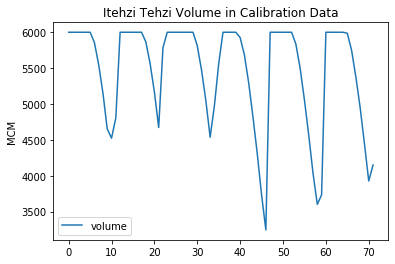

In [44]:
streamflow_figure = plt.figure()
streamflow_figure = plt.title('Itehzi Tehzi Volume in Calibration Data')
streamflow_figure = plt.ylabel("MCM")
streamflow_figure = plt.plot(calibration_df.index, calibration_df['it_volume'], label = 'volume')
streamflow_figure = plt.legend()
streamflow_figure = plt.show()

## 3. <font color = blue> Python-to-Excel Model Validations </font>

#### <font color = purple> Itehzi Tezhi Hydropower Demand Errors </font>

In [45]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
it_hydro_demand_test_df = pd.read_csv("Inputs/Calibration/it_hydro_demand.csv")
it_hydro_demand_test_df.set_index('timestep', inplace=True)
it_hydro_demand_test_df = it_hydro_demand_test_df.rename(columns = {'hydro_demand':'it_test_hydro_demand'})
it_hydro_demand_error_df = calibration_df.merge(it_hydro_demand_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in it_hydro_demand_error_df.iterrows():    
    it_hydro_demand_error_df.at[index,'it_hydro_demand_error'] = row['it_test_hydro_demand'] - row['it_hydro_demand']
it_hydro_demand_error_df.head()

,timestep,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,...,kg_runoff,it_streamflow,kg_streamflow,it_volume,it_hydro_demand,it_gated_release,it_spilled_release,it_outflow,it_test_hydro_demand,it_hydro_demand_error
0,1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.410688,...,1.744628e+03,4656.051958,2310.283970,5999.935757,648.906769,648.906769,1861.722316,2510.629085,752.906769,104.0
1,2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.983190,...,9.864780e+02,3704.195241,1837.982687,5999.900001,591.342459,591.342459,3112.788539,3704.130998,695.342459,104.0
2,3,1,3,97.6,17,29,155.684118,13.289974,221.110468,62.670465,...,7.722060e-02,2041.236669,1012.840149,5999.900002,648.906769,648.906769,1392.229901,2041.136670,1426.906769,778.0
3,4,1,4,5.6,14,29,169.238425,0.776610,148.598863,15.582097,...,1.884013e-12,1680.439559,833.816420,5999.900002,627.974292,627.974292,1052.365268,1680.339560,731.974292,104.0
4,5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.754996,...,0.000000e+00,1129.351359,560.372256,5999.900002,648.906769,648.906769,480.344592,1129.251361,752.906769,104.0


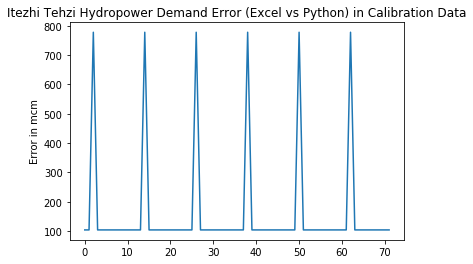

In [46]:
it_hydro_demand_error_figure = plt.figure()
it_hydro_demand_error_figure = plt.title('Itezhi Tehzi Hydropower Demand Error (Excel vs Python) in Calibration Data')
it_hydro_demand_error_figure = plt.ylabel("Error in mcm")
it_hydro_demand_error_figure = plt.plot(it_hydro_demand_error_df.index, it_hydro_demand_error_df['it_hydro_demand_error'])
it_hydro_demand_error_figure = plt.show()

#### <font color = purple> Itehzi Tezhi Hydropower Releases Error </font>

In [47]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
it_gated_release_test_df = pd.read_csv("Inputs/Calibration/it_gated_release.csv")
it_gated_release_test_df.set_index('timestep', inplace=True)
it_gated_release_test_df = it_gated_release_test_df.rename(columns = {'gated_release':'it_test_gated_release'})
it_gated_release_error_df = calibration_df.merge(it_gated_release_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in it_gated_release_error_df.iterrows():    
    it_gated_release_error_df.at[index,'it_gated_release_error'] = row['it_test_gated_release'] - row['it_gated_release']
it_gated_release_error_df.head()

,timestep,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,...,kg_runoff,it_streamflow,kg_streamflow,it_volume,it_hydro_demand,it_gated_release,it_spilled_release,it_outflow,it_test_gated_release,it_gated_release_error
0,1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.410688,...,1.744628e+03,4656.051958,2310.283970,5999.935757,648.906769,648.906769,1861.722316,2510.629085,752.906769,104.0
1,2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.983190,...,9.864780e+02,3704.195241,1837.982687,5999.900001,591.342459,591.342459,3112.788539,3704.130998,695.342459,104.0
2,3,1,3,97.6,17,29,155.684118,13.289974,221.110468,62.670465,...,7.722060e-02,2041.236669,1012.840149,5999.900002,648.906769,648.906769,1392.229901,2041.136670,1426.906769,778.0
3,4,1,4,5.6,14,29,169.238425,0.776610,148.598863,15.582097,...,1.884013e-12,1680.439559,833.816420,5999.900002,627.974292,627.974292,1052.365268,1680.339560,731.974292,104.0
4,5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.754996,...,0.000000e+00,1129.351359,560.372256,5999.900002,648.906769,648.906769,480.344592,1129.251361,752.906769,104.0


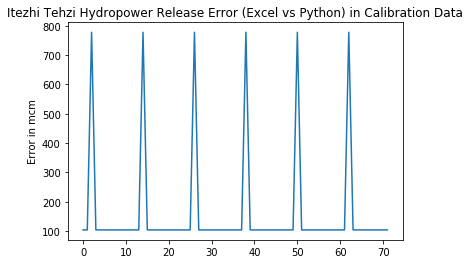

In [48]:
it_gated_release_error_figure = plt.figure()
it_gated_release_error_figure = plt.title('Itezhi Tehzi Hydropower Release Error (Excel vs Python) in Calibration Data')
it_gated_release_error_figure = plt.ylabel("Error in mcm")
it_gated_release_error_figure = plt.plot(it_gated_release_error_df.index, it_gated_release_error_df['it_gated_release_error'])
it_gated_release_error_figure = plt.show()

#### <font color = purple> Itehzi Tezhi Spilled Release Errors </font>

In [49]:
os.chdir("C:/Users/q0hecjrk/Documents/_Data/Iolanda/")
it_spilled_release_test_df = pd.read_csv("Inputs/Calibration/it_spilled_release.csv")
it_spilled_release_test_df.set_index('timestep', inplace=True)
it_spilled_release_test_df = it_spilled_release_test_df.rename(columns = {'spilled_release':'it_test_spilled_release'})
it_spilled_release_error_df = calibration_df.merge(it_spilled_release_test_df.drop(['year', 'month'], axis=1), how='left', on='timestep')
for index, row in it_spilled_release_error_df.iterrows():    
    it_spilled_release_error_df.at[index,'it_spilled_release_error'] = row['it_test_spilled_release'] - row['it_spilled_release']
it_spilled_release_error_df.head()

,timestep,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,...,kg_runoff,it_streamflow,kg_streamflow,it_volume,it_hydro_demand,it_gated_release,it_spilled_release,it_outflow,it_test_spilled_release,it_spilled_release_error
0,1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.410688,...,1.744628e+03,4656.051958,2310.283970,5999.935757,648.906769,648.906769,1861.722316,2510.629085,0.000000,-1861.722316
1,2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.983190,...,9.864780e+02,3704.195241,1837.982687,5999.900001,591.342459,591.342459,3112.788539,3704.130998,1761.122625,-1351.665914
2,3,1,3,97.6,17,29,155.684118,13.289974,221.110468,62.670465,...,7.722060e-02,2041.236669,1012.840149,5999.900002,648.906769,648.906769,1392.229901,2041.136670,3003.294416,1611.064515
3,4,1,4,5.6,14,29,169.238425,0.776610,148.598863,15.582097,...,1.884013e-12,1680.439559,833.816420,5999.900002,627.974292,627.974292,1052.365268,1680.339560,614.307831,-438.057437
4,5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.754996,...,0.000000e+00,1129.351359,560.372256,5999.900002,648.906769,648.906769,480.344592,1129.251361,948.439806,468.095215


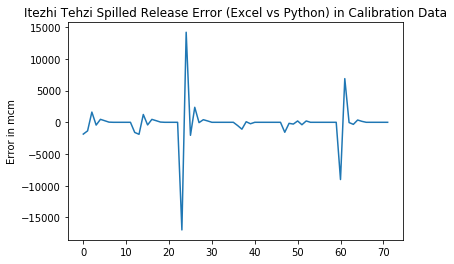

In [50]:
it_spilled_release_error_figure = plt.figure()
it_spilled_release_error_figure = plt.title('Itezhi Tehzi Spilled Release Error (Excel vs Python) in Calibration Data')
it_spilled_release_error_figure = plt.ylabel("Error in mcm")
it_spilled_release_error_figure = plt.plot(it_spilled_release_error_df.index, it_spilled_release_error_df['it_spilled_release_error'])
it_spilled_release_error_figure = plt.show()

## 4. <font color = blue> Kafue Gorge calibration period computation </font>

In [86]:
#volume = -31793 + 82.143*depth
def kg_depth(volume):
    return (volume + 31793) / 82.143
def kg_volume(depth):
    return -31793 + 82.143*depth

In [87]:
loss_to_ground = 0.30 #it release loss to groundwater
def kg_inflow(kg_streamflow, it_outflow_t_minus_2, loss_to_ground, month):
    days_in_month = { 1:31, 2:28.25, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    irrigation_demand = { 1:7.34, 2:9.75, 3:12.09, 4:18.95, 5:19.77, 6:16.99, 7:17.06, 8:19.42, 9:22.62, 10:17.11, 11:12.89, 12:7.54}
    wtp_demand = 0.88 * days_in_month[month] # mcm per month
    extractions = wtp_demand + irrigation_demand[month]
    return max(0, kg_streamflow + it_outflow_t_minus_2 * (1 - loss_to_ground) - extractions)

In [88]:
kg_target = 792 # megawatts per month
kg_efficiency = 0.90 * 0.91 #(1- headloss) * effeciency
kg_initial_volume = 650 # mcm
kg_deadpool_volume = 456 # mcm

In [89]:
def hydro_production(release, depth, efficiency, month):
    days_in_month = { 1:31, 2:28.25, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    return (9.81 * 1000.0 * release * depth * efficiency) / (86400.0 * days_in_month[month])

In [90]:
def kg_demand(kg_hydropower_demand):
    kg_eflows_demand = 0.78 # mcm
    return kg_hydropower_demand + kg_eflows_demand

In [91]:
def kafue_gorge_reservoir(df, initial_volume, deadpool, surcharge, loss_to_ground, efficiency, target, loss_max):
    volume = initial_volume
    for index, row in df.iterrows():
        if index < 2:
            if index == 0:
                it_outflow_t_minus_2 = row['it_outflow']
            if index == 1:
                it_outflow_t_minus_2 = row['it_outflow']
        else:
            #compute values
            depth = kg_depth(volume)
            inflow = kg_inflow(row['kg_streamflow'], it_outflow_t_minus_2, loss_to_ground, row['month'])
            demand = hydropower_demand_release(depth, row['month'], efficiency, target)
            release = reservoir_gated_release(volume, deadpool, inflow, kg_demand(demand))
            hydro_release = max(0, release - 0.78)
            production = hydro_production(release, depth, efficiency, row['month'])
            spill = reservoir_spilled_release(volume, inflow, release, surcharge)
            volume = reservoir_volume(volume, inflow, release, spill, loss_max, surcharge)
            #comit to data frame
            df.at[index,'kg_depth'] = depth
            df.at[index,'kg_inflow'] = inflow
            df.at[index,'kg_hydro_demand'] = demand
            df.at[index,'kg_gated_release'] = release
            df.at[index,'kg_hydro_release'] = max(0, release - 0.78)
            df.at[index,'kg_hydro_production'] = production
            df.at[index,'kg_hydro_shortfall'] = target - production
            df.at[index,'kg_spilled_release'] = spill
            df.at[index,'kg_volume'] = volume
            #update values
            it_outflow_t_minus_1 = it_outflow_t_minus_2
            it_outflow_t_minus_2 = row['it_outflow']
    return df

In [92]:
loss_to_ground = loss_to_ground

kg_target = kg_target
kg_efficiency = kg_efficiency
kg_loss_max = 0.10 #mcm at full volume
kg_initial_volume = kg_initial_volume
kg_deadpool_volume = kg_deadpool_volume
kg_surcharge_volume = 900 #mcm

calibration_df = kafue_gorge_reservoir(calibration_df, kg_initial_volume, kg_deadpool_volume, kg_surcharge_volume, loss_to_ground, kg_efficiency, kg_target, kg_loss_max)
calibration_df.head()

,timestep,year,month,kaoma_precip,min_temp,max_temp,pet,soil_storage,ground_storage,et,...,it_outflow,kg_depth,kg_inflow,kg_hydro_demand,kg_gated_release,kg_hydro_release,kg_hydro_production,kg_hydro_shortfall,kg_spilled_release,kg_volume
0,1,1,1,242.5,18,29,132.172078,28.283486,225.801021,75.410688,...,2510.629085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,2,209.1,18,29,123.883007,28.163281,268.563295,70.983190,...,3704.130998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,3,97.6,17,29,155.684118,13.289974,221.110468,62.670465,...,2041.136670,394.957574,3566.361847,668.493613,669.273613,668.493613,792.924108,-0.924108,2647.088234,899.927778
3,4,1,4,5.6,14,29,169.238425,0.776610,148.598863,15.582097,...,1680.339560,398.000168,2217.262089,641.983719,642.763719,641.983719,792.962267,-0.962267,1574.426148,899.900008
4,5,1,5,0.0,10,28,165.057973,0.005212,99.561238,0.754996,...,1129.251361,397.999830,1689.559949,663.383740,664.163740,663.383740,792.931226,-0.931226,1025.296217,899.900011


In [101]:
def process_trace_data_reservoirs(in_dir, out_dir, \
                                  it_initial_volume, it_deadpool_volume, it_surcharge_volume, it_efficiency, it_target, it_losses, \
                                  kg_initial_volume, kg_deadpool_volume, kg_surcharge_volume, loss_to_ground, kg_efficiency, kg_target, kg_loss_max):
    for file_name in os.listdir(in_directory):
        df = pd.read_csv(in_directory + '/' + file_name)
        df.set_index('timestep', inplace=True, drop=True, verify_integrity=True)
        df = itezhi_tehzi_reservoir(df, it_initial_volume, it_deadpool_volume, it_surcharge_volume, it_efficiency, it_target, it_losses)
        df = kafue_gorge_reservoir(df, kg_initial_volume, kg_deadpool_volume, kg_surcharge_volume, loss_to_ground, kg_efficiency, kg_target, kg_loss_max)
        df.to_csv(out_directory + '/' + file_name)           

In [103]:
in_directory = "C:/Users/q0hecjrk/Documents/_Data/Iolanda/Outputs/streamflow"
out_directory = "C:/Users/q0hecjrk/Documents/_Data/Iolanda/Outputs/reservoirs"

it_target = it_target
it_losses = it_losses
it_efficiency = it_efficiency
it_volume = it_initial_volume
it_deadpool = it_deadpool_volume
it_surcharge = it_surcharge_volume

loss_to_ground = loss_to_ground
kg_target = kg_target
kg_losses = kg_loss_max
kg_efficiency = kg_efficiency
kg_volume = kg_initial_volume
kg_deadpool = kg_deadpool_volume
kg_surcharge = kg_surcharge_volume

process_trace_data_reservoirs(in_directory, out_directory, \
                              it_volume, it_deadpool, it_surcharge, it_efficiency, it_target, it_losses, \
                              kg_volume, kg_deadpool, kg_surcharge, loss_to_ground, kg_efficiency, kg_target, kg_losses)